# Using uDALES utilities in Python
This tutorial demonstrates how to use the uDALES Python utilities for post-processing simulation data. It covers 1) time-averaging; 2) merging short-term time-averaged data to long-term averages, and 3) coarse-graining fields for Spatial filtering (coarse-graining method). The utility functions include:
- **time_average**. This routine calculates the time-average of a quantity (assumes time is in the last index of the variable).
- **merge_stat**. This routine merges the short-term time average and (co)variance into long-term averages and associated (co)variance.
- **coarsegrain_field**. This routine allows you to coarse-grain a field using a planar filter in the x-y plane using a fixed lengthscale [1].


In [1]:
from pathlib import Path
import sys
import types
import numpy as np
import matplotlib.pyplot as plt
import trimesh  # type: ignore

sys.path.insert(0, '../../tools/python')
from udbase import UDBase


## time_average: time-averaged mean and variance of instantaneous data
`time_average` function returns the mean of time-series data (fields, facets, timeseries, ...). The method assumes that time is the last array index.


In [2]:
# Display help for time_average
help(UDBase.time_average)


Help on function time_average in module udbase:

time_average(var: numpy.ndarray, other: Optional[numpy.ndarray] = None)
    Time-average variables.

    Parameters
    ----------
    var : ndarray
        Variable to average. Time must be the last dimension.
    other : ndarray, optional
        Second variable (same shape as ``var``) to compute covariance with.

    Returns
    -------
    tuple
        - (mean, variance) when only ``var`` is provided
        - (x_mean, y_mean, covariance) when ``other`` is provided

    Notes
    -----
    Variance/covariance are computed by delegating to ``merge_stat`` with
    zero instantaneous contributions.



For example, let's load instantaneous pressure data for facets:


In [3]:
# preamble
expnr = '065'  # Experiment number
expdir = Path(r'C:/Users/mvr/OneDrive - Imperial College London/projects/2024_uDALES_sprint/udales-pp/experiments/065')
sim = UDBase(expnr=expnr, path=expdir)

p = sim.load_fac_momentum('pres')
t = sim.load_fac_momentum('t')


Loaded geometry: 2658 faces, 1411 vertices


Now, let's calculate pressure mean and variance


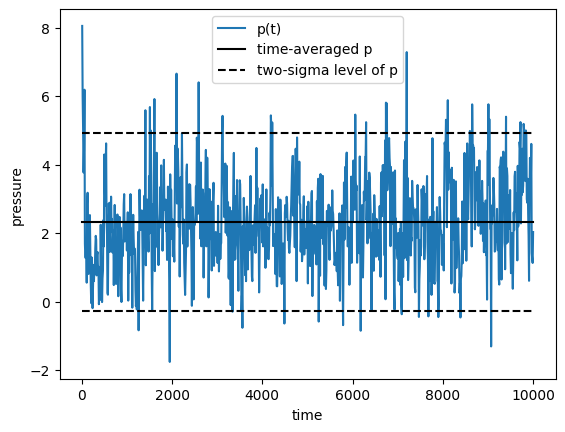

In [4]:
pav, pvar = UDBase.time_average(p)

# Plot the time-series of p together with the mean and the 95% confidence interval
fig, ax = plt.subplots()
ax.plot(t, p[0, :], label='p(t)')
ax.plot(t, np.ones_like(t) * pav[0], 'k-', label='time-averaged p')
ax.plot(t, np.ones_like(t) * (pav[0] + 2 * np.sqrt(pvar[0])), 'k--', label='two-sigma level of p')
ax.plot(t, np.ones_like(t) * (pav[0] - 2 * np.sqrt(pvar[0])), 'k--')
ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('pressure')
plt.show()


The function can also be used to calculated the time average and covariance of two variables. For example, let's calculate the covariance of the facet pressure and x-component shear stress $\overline{p'\tau_x'}$:


In [5]:
taux = sim.load_fac_momentum('tau_x')
pbar, tauxbar, ptauxbar = UDBase.time_average(p, taux)

# check output for the first facet
print(
    "The time-averaged pressure pbar={:.3f} m2/s2, tauxbar={:.3f} m2/s2 and their covariance p'taux'bar={:.3f} m4/s4."
    .format(pbar[0, 0], tauxbar[0, 0], ptauxbar[0, 0])
)


The time-averaged pressure pbar=2.314 m2/s2, tauxbar=-0.032 m2/s2 and their covariance p'taux'bar=0.049 m4/s4.


## merge_stat: combine short-term time average into a long-term time average 
uDALES statistics are collected over fixed time-windows. Sometimes these time windows may be a bit too short. The function `merge_stat` is able to combine several of time-windows into larger ones.


Let's start with loading short-term time-averaged data, for example the 1-D plane average


In [6]:
# Use a different simulation
expnr = 110  # Experiment number
expdir = Path(r'C:/Users/mvr/OneDrive - Imperial College London/projects/2024_uDALES_sprint/udales-pp/experiments/110')
sim = UDBase(expnr=expnr, path=expdir)

# load xy- and time-averaged data
ds_xyt = sim.load_stat_xyt() 

uxyt = ds_xyt['uxyt']  # u-velocity profile (z) [m/s]
wxyt = ds_xyt['wxyt']        # w-velocity profile [m/s]
upupxyt = ds_xyt['upuptxyc'] # u-velocity variance [m2/s2]
upwpxyt = ds_xyt['upwpxyt']  # u-w velocity covariance [m2/s2]
time = ds_xyt['time']        # Time coordinate for xyt data [s]

Loaded geometry: 1102 faces, 624 vertices

Contents of xytdump.110.nc:
Name                 Dimensions                     Shape               
----------------------------------------------------------------------
pxyt                 zt, time                       256 x 3             
qtxyt                zt, time                       256 x 3             
thlpthlptxy          zt, time                       256 x 3             
thlsgsxyt            zm, time                       256 x 3             
thlxyt               zt, time                       256 x 3             
tketxyc              zt, time                       256 x 3             
upuptxyc             zt, time                       256 x 3             
upvpxyt              zm, time                       256 x 3             
upwpxyt              zm, time                       256 x 3             
usgsxyt              zm, time                       256 x 3             
uvxyt                zm, time                       256

c:\Users\mvr\OneDrive - Imperial College London\codes\uDALES\u-dales\docs\tutorial_mlx\../../tools/python\udbase.py:172: UserWarning: prof.inp.110 not found. Assuming equidistant grid.
  warnings.warn(f"prof.inp.{self.expnr} not found. Assuming equidistant grid.")


Check the averaging time interval


In [7]:
print(time)
print(len(time))


<xarray.DataArray 'time' (time: 3)> Size: 12B
array([2000.1102, 4000.0815, 6000.117 ], dtype=float32)
Coordinates:
  * time     (time) float32 12B 2e+03 4e+03 6e+03
Attributes:
    longname:  Time
    units:     s
3


So there are three time-averaging intervals. Long-term time averaging can be used by using


In [8]:
help(UDBase.merge_stat)


Help on function merge_stat in module udbase:

merge_stat(X: numpy.ndarray, *args, Y: Optional[numpy.ndarray] = None, XpXp: Optional[numpy.ndarray] = None, XpYp: Optional[numpy.ndarray] = None)
    Merge short-term statistics into longer windows.

    Supported call patterns:
      - merge_stat(X, n)
      - merge_stat(X, XpXp, n)
      - merge_stat(X, Y, XpYp, n)
      - merge_stat(X, n, XpXp=array)            # single variable mean/variance
      - merge_stat(X, n, Y=array, XpYp=array)   # two variables mean/cov

    Parameters
    ----------
    X : ndarray
        First variable. Final dimension is time or short-term windows.
    args : tuple
        Positional parameters parsed according to the patterns above.
    Y : ndarray, optional
        Second variable (same trailing dimension as ``X``).
    XpXp : ndarray, optional
        Variance contribution for ``X`` aligned with ``X``.
    XpYp : ndarray, optional
        Covariance contribution for ``X`` and ``Y`` aligned with ``X``.

This function needs all the short-term variables related as the input, plus an average time window. The long-term average is simply the average of the short-term averages, but the long-term variance contains both contribution from variance in the short-term mean and the short term variance. Please ensure that the last dimension of the input must be the time, as the function merges on that dimension.


Let's start with two variables and their covariance, obtaining long-term quantities for $\overline u$, $\bar{w}$ and their covariance $\overline{u'w'}$ over all three time segments:


In [16]:
Nwindow = len(time)

# input all the short-term variables related
uxyt_longterm, wxyt_longterm, upwpxyt_longterm = UDBase.merge_stat(uxyt, wxyt, upwpxyt, Nwindow)


if you only need one variable, e.g., the long-term quantities for $\overline u$ and $\overline{u'u'}$ over all time, you can reduce it to:


In [17]:
uxyt_longterm, upupxyt_longterm = UDBase.merge_stat(uxyt, upupxyt, Nwindow)


Naturally both versions return the same value for `uxyt_longterm.` Let's check the dimension of the short-term and long-term statistics


In [18]:
print(uxyt.shape)
print(uxyt_longterm.shape)


(256, 3)
(256, 1)


If you want an average over shorter window, you can use an optional parameter to `merge_stat`:


In [19]:
Nwindow = 2
uxyt_longterm, upupxyt_longterm = UDBase.merge_stat(uxyt, upupxyt, Nwindow)
print(uxyt_longterm.shape)


(256, 1)


There were three intervals in uxut, and the last two were used to average over. The first time-interval has been discarded.


## coarsegrain_field: coarse-graining 3D fields
We recently developed a coarse-graining method that is computationally efficient and can be used to coarse-grain data [1]. In order to demonstrate its use, let's load the mean horizontal velocity $\\overline{u}$ from the uDALES data.


In [20]:
ut = sim.load_stat_t('ut')

The coarse-graining routine has the following syntax:


In [21]:
help(UDBase.coarsegrain_field)


Help on function coarsegrain_field in module udbase:

coarsegrain_field(var: numpy.ndarray, Lflt: numpy.ndarray, xm: numpy.ndarray, ym: numpy.ndarray) -> numpy.ndarray
    Apply 2D periodic box filters to a 3D field.

    Parameters
    ----------
    var : ndarray, shape (nx, ny, nz)
        Field data (time or height on the last axis).
    Lflt : array-like
        Filter lengths (meters). Multiple lengths are allowed.
    xm, ym : array-like
        Grid coordinates in meters; must be 1D and roughly uniform.

    Returns
    -------
    ndarray
        Filtered field with shape (nx, ny, nz, n_filters).



The routine takes in multiple filter lengths simultaneously.


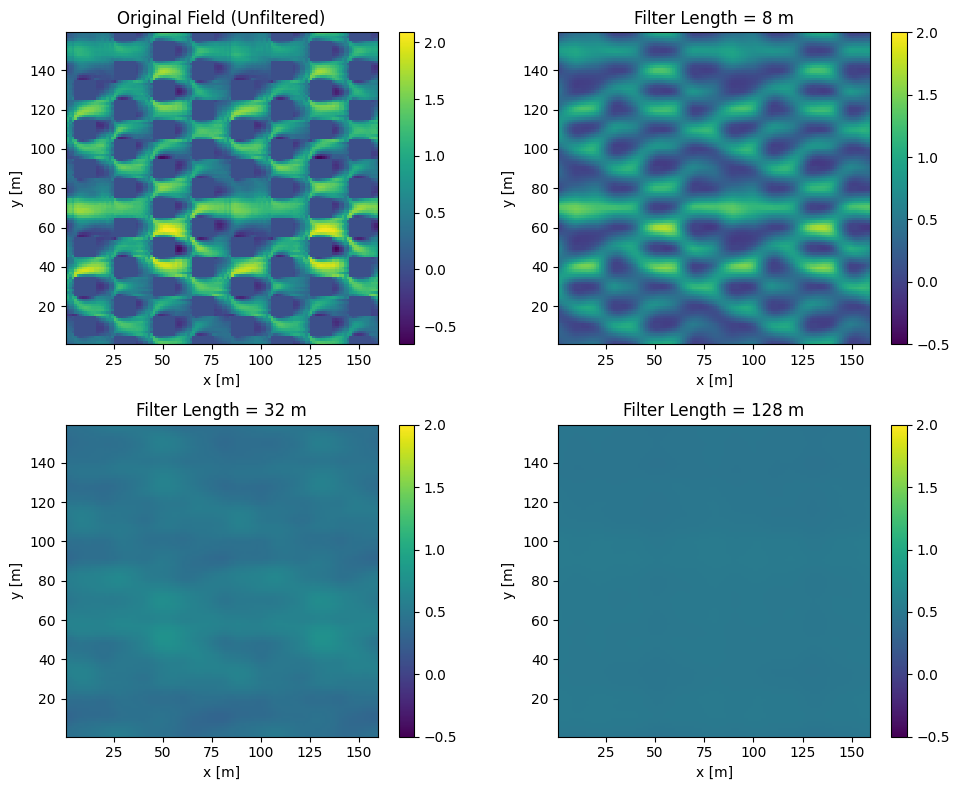

In [22]:
filter_lengths = [8, 32, 128]  # Filter widths in meters

# filter the last field
u_filtered = UDBase.coarsegrain_field(ut[:, :, :, -1], filter_lengths, sim.xm, sim.ym)

# Create figure with subplots comparing original and filtered fields
fig = plt.figure(figsize=(10, 8))

k_level = 10
# Original field (unfiltered)
ax = fig.add_subplot(2, 2, 1)
pc = ax.pcolormesh(sim.xt, sim.yt, ut[:, :, k_level, -1].T, shading='auto')
ax.set_aspect('equal')
ax.set_xlim(sim.xt.min(), sim.xt.max())
ax.set_ylim(sim.yt.min(), sim.yt.max())
fig.colorbar(pc, ax=ax)
ax.set_title('Original Field (Unfiltered)')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

filter_titles = [
    f'Filter Length = {filter_lengths[0]:.0f} m',
    f'Filter Length = {filter_lengths[1]:.0f} m',
    f'Filter Length = {filter_lengths[2]:.0f} m'
]

for i in range(3):
    ax = fig.add_subplot(2, 2, i + 2)
    pc = ax.pcolormesh(sim.xt, sim.yt, u_filtered[:, :, k_level, i].T, shading='auto')
    pc.set_clim([-0.5, 2])
    ax.set_aspect('equal')
    ax.set_xlim(sim.xt.min(), sim.xt.max())
    ax.set_ylim(sim.yt.min(), sim.yt.max())
    fig.colorbar(pc, ax=ax)
    ax.set_title(filter_titles[i])
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')

plt.tight_layout()
plt.show()


## References
[1] Maarten van Reeuwijk, Jingzi Huang (2025) Multi-scale Analysis of Flow over Heterogeneous Urban Environments, Bound-Lay. Met. 191, 47.
